In [1]:
%matplotlib inline

import importlib


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

import common
importlib.reload(common)

from common import create_engine
from common import display_all
from common import figsize
from common import save_df


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [2]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Nacitanie dat z db (live data z monant snapshotu)

In [3]:
create_view_query = '''
DROP MATERIALIZED VIEW IF EXISTS article_fb_latest;
CREATE MATERIALIZED VIEW article_fb_latest AS
(
SELECT sbq.url, sbq.sync_date, sbq.reaction_count, sbq.comment_count, sbq.share_count
FROM (
         SELECT afe.*, row_number() OVER (PARTITION BY url ORDER BY sync_date DESC) as rn
         FROM article_fb_engagement afe
     ) sbq
WHERE sbq.rn = 1)
'''

with engine.connect() as connection:
    connection.execute(create_view_query)

In [28]:
fetch_data_query = '''
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       published_at,
       extracted_at,
       a.source_id,
       category,
       other_info,
       coalesce(imgc.cnt, 0)                          as image_count,
       coalesce(vidc.cnt, 0)                          as video_count,
       av.veracity,
       av.claims_false,
       av.claims_mixture,
       av.claims_mostly_false,
       av.claims_mostly_true,
       av.claims_true,
       av.claims_unknown,
       aut.name                                       as author_name,
       s.id                                           as source_id,
       s.name                                         as source_name,
       s.url                                          as source_url,
       stype                                          as source_type,
       is_reliable::integer                           as source_is_reliable,
       sync_date                                      as fb_sync_date,
       reaction_count                                 as fb_reaction_count,
       comment_count                                  as fb_comment_count,
       share_count                                    as fb_share_count,
       (reaction_count + comment_count + share_count) as fb_popularity
FROM article a
         JOIN source s on a.source_id = s.id
         JOIN (SELECT * FROM article_fb_latest) p ON a.url = p.url
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'image' GROUP BY article_id) imgc
                   ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'video' GROUP BY article_id) vidc
                   ON a.id = vidc.article_id
         JOIN article_veracity av on a.id = av.article_id
WHERE s.url !~ '(\.sk$)|(\.cz$)' -- remove cz/sk sources
  AND s.name NOT IN ('badatel.net', -- cz/sk portals not using cz/sk domain
                     'energiezivota.com')
  AND a.published_at IS NOT NULL
  AND s.is_reliable IS NOT NULL;
'''

df = pd.sql(fetch_data_query)
df_copy = df.copy()

In [ ]:
mviews_queries = [
    '''
    DROP MATERIALIZED VIEW IF EXISTS news_articles;
    CREATE MATERIALIZED VIEW news_articles AS (
    SELECT *
    FROM article
    WHERE monitor_id in (1, 4, 5, 7, 8, 9, 10)
      AND published_at >= '2019-10-14 15:29:44.600421');
    ''',
    '''
    DROP MATERIALIZED VIEW IF EXISTS article_fb_engagement_per_day;
    CREATE MATERIALIZED VIEW article_fb_engagement_per_day AS (
    SELECT max(id) last_id_on_day, url, sync_date::date as sync_on_day
    FROM article_fb_engagement
    GROUP BY url, sync_on_day);
    ''',
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles_fb_engagement;
    CREATE MATERIALIZED VIEW new_articles_fb_engagement AS
    (
    SELECT afe.id,
           afe.url,
           afe.reaction_count,
           afe.comment_count,
           afe.share_count,
           afe.comment_plugin_count,
           afepd.sync_on_day,
           na.published_at,
           afepd.sync_on_day - na.published_at::date as days_after_publication
    FROM article_fb_engagement_per_day afepd
             JOIN article_fb_engagement afe ON afe.id = afepd.last_id_on_day
             JOIN news_articles na ON na.url = afepd.url);
    '''    
]

with engine.connect() as connection:
    for q in mviews_queries:
        connection.execute(q)

In [286]:
df = pd.sql('''
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       a.published_at,
       extracted_at,
       a.source_id,
       category,
       other_info,
       coalesce(imgc.cnt, 0)                          as image_count,
       coalesce(vidc.cnt, 0)                          as video_count,
       av.veracity,
       av.claims_false,
       av.claims_mixture,
       av.claims_mostly_false,
       av.claims_mostly_true,
       av.claims_true,
       av.claims_unknown,
       aut.name                                       as author_name,
       s.id                                           as source_id,
       s.name                                         as source_name,
       s.url                                          as source_url,
       stype                                          as source_type,
       is_reliable::integer                           as source_is_reliable
FROM news_articles a
         JOIN source s on a.source_id = s.id
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'image' GROUP BY article_id) imgc
                   ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'video' GROUP BY article_id) vidc
                   ON a.id = vidc.article_id
         JOIN article_veracity av on a.id = av.article_id
WHERE s.is_reliable IS NOT NULL;
''')

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3812 entries, 0 to 3811
Data columns (total 25 columns):
id                     3812 non-null int64
url                    3812 non-null object
title                  3812 non-null object
perex                  2845 non-null object
body                   3807 non-null object
published_at           3812 non-null datetime64[ns]
extracted_at           3812 non-null datetime64[ns]
source_id              3812 non-null int64
category               2260 non-null object
other_info             3810 non-null object
image_count            3812 non-null int64
video_count            3812 non-null int64
veracity               3812 non-null object
claims_false           3812 non-null int64
claims_mixture         3812 non-null int64
claims_mostly_false    3812 non-null int64
claims_mostly_true     3812 non-null int64
claims_true            3812 non-null int64
claims_unknown         3812 non-null int64
author_name            3812 non-null object
source_

In [288]:
nafe = pd.sql('''
SELECT url,
       reaction_count,
       share_count,
       comment_count,
       comment_plugin_count,
       sync_on_day,
       days_after_publication
FROM new_articles_fb_engagement;
''')

In [289]:
nafe = nafe[nafe.days_after_publication.isin(list(range(0, 15)))].copy()

In [290]:
cols = [
    'url',
    'days_after_publication',
    'reaction_count',
    'share_count',
    'comment_count'
] 

popularity = nafe[cols].pivot('url', 'days_after_publication').reset_index()
popularity = popularity.set_index('url')
popularity.columns = [f'fb_ad_{j}_{i}' for i,j in popularity.columns.values]

In [291]:
df = df.set_index('url')

In [292]:
x_df = pd.concat((df, x), axis=1, join='inner')

In [293]:
x_df

,id,title,perex,body,published_at,extracted_at,source_id,category,other_info,image_count,...,fb_ad_5_comment_count,fb_ad_6_comment_count,fb_ad_7_comment_count,fb_ad_8_comment_count,fb_ad_9_comment_count,fb_ad_10_comment_count,fb_ad_11_comment_count,fb_ad_12_comment_count,fb_ad_13_comment_count,fb_ad_14_comment_count
url,,,,,,,,,,,,,,,,,,,,,
https://naturalnewsblogs.com/sugar-is-not-sweet/,430166,Sugar is not sweet,<p>Heart disease is the leading cause of death...,Heart disease is the leading cause of death in...,2019-10-14 17:14:23,2019-10-15 03:54:24.343870,142,[Health],"{'tags': [], 'updated_at': '2019-10-14T17:14:24'}",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://naturalnewsblogs.com/how-fluoride-a-toxin-got-in-our-water-and-iodine-a-critical-nutrient-disappeared-from-medical-school-textbooks/,430168,"How Fluoride (a toxin) got in our water, and I...","<p>If you were a woman with painful, cystic br...","If you were a woman with painful, cystic breas...",2019-10-14 17:46:13,2019-10-15 03:54:24.807962,142,"[Health, Science, Videos, Fluoride, Medicine, ...","{'tags': ['""The Iodine Crisis""', 'brominated f...",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://www.healthnutnews.com/vitamin-a-can-save-your-skin/,430178,Vitamin A Can Save Your Skin,"<p>Written by Joseph Mercola, D.O., Ph.D. Stor...","\n\n\nWritten by Joseph Mercola, D.O., Ph.D.\n...",2019-10-14 15:35:19,2019-10-15 05:45:32.471265,176,"[Health, Food]","{'tags': ['Astaxanthin', 'dangers of sunscreen...",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://www.healthnutnews.com/ny-times-in-the-pancreas-common-fungi-may-drive-cancer/,430180,"NY Times: In the Pancreas, Common Fungi May Dr...","<p>By now, you&#8217;ve probably heard that yo...","By now, you’ve probably heard that your body i...",2019-10-14 21:49:41,2019-10-15 05:45:35.141698,176,[Health],"{'tags': ['bacteria', 'digestive enzymes', 'fu...",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://hsionline.com/2019/10/14/federal-crackdown-milk-trick/,430181,Federal CRACKDOWN suppresses mind-sharpening b...,<p>You drive over to one of those “superstores...,You drive over to one of those “superstores”… ...,2019-10-14 18:00:21,2019-10-15 05:58:25.540033,177,"[Memory, Facebook, eAlert News]","{'tags': ['Alzheimer’s'], 'updated_at': '2019-...",0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.latimes.com/california/story/2020-03-18/coronavirus-california-asks-navy-for-hospital-ship-mobile-hospitals,804027,"Battling coronavirus, California asks Navy for...",Coronavirus: California asks Navy for a hospit...,Gov. Gavin Newsom said Wednesday that the stat...,2020-03-19 03:52:44,2020-03-19 04:35:02.989354,202,[None],"{'tags': ['Health: Coronavirus'], 'keywords': ...",1,...,109.00000,110.00000,110.00000,110.00000,110.00000,110.00000,110.00000,nan,nan,nan
https://www.medicaldaily.com/trying-keto-diet-amid-covid-19-pandemic-need-expect-flu-symptoms-450685,804046,Trying Keto Diet Amid COVID-19 Pandemic? You N...,None,The much talked about keto diet involves sacri...,2020-03-19 01:54:24,2020-03-19 07:39:05.603981,164,None,"{'tags': [], 'keywords': ['keto diet', 'covid-...",1,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,nan,nan
http://www.medicinenet.com/script/main/art.asp?articlekey=228946,804077,Minorities Less Likely to Get Recommended Lung...,Title: Minorities Less Likely to Get Recommend...,"TUESDAY, March 17, 2020 (HealthDay News) -- Bl...",2020-03-19 08:00:00,2020-03-19 10:35:44.002041,186,[None],"{'tags': [], 'keywords': ['Minorities Less Lik...",1,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,nan,nan


In [295]:
x_df

,id,title,perex,body,published_at,extracted_at,source_id,category,other_info,image_count,...,fb_ad_5_comment_count,fb_ad_6_comment_count,fb_ad_7_comment_count,fb_ad_8_comment_count,fb_ad_9_comment_count,fb_ad_10_comment_count,fb_ad_11_comment_count,fb_ad_12_comment_count,fb_ad_13_comment_count,fb_ad_14_comment_count
url,,,,,,,,,,,,,,,,,,,,,
https://naturalnewsblogs.com/sugar-is-not-sweet/,430166,Sugar is not sweet,<p>Heart disease is the leading cause of death...,Heart disease is the leading cause of death in...,2019-10-14 17:14:23,2019-10-15 03:54:24.343870,142,[Health],"{'tags': [], 'updated_at': '2019-10-14T17:14:24'}",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://naturalnewsblogs.com/how-fluoride-a-toxin-got-in-our-water-and-iodine-a-critical-nutrient-disappeared-from-medical-school-textbooks/,430168,"How Fluoride (a toxin) got in our water, and I...","<p>If you were a woman with painful, cystic br...","If you were a woman with painful, cystic breas...",2019-10-14 17:46:13,2019-10-15 03:54:24.807962,142,"[Health, Science, Videos, Fluoride, Medicine, ...","{'tags': ['""The Iodine Crisis""', 'brominated f...",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://www.healthnutnews.com/vitamin-a-can-save-your-skin/,430178,Vitamin A Can Save Your Skin,"<p>Written by Joseph Mercola, D.O., Ph.D. Stor...","\n\n\nWritten by Joseph Mercola, D.O., Ph.D.\n...",2019-10-14 15:35:19,2019-10-15 05:45:32.471265,176,"[Health, Food]","{'tags': ['Astaxanthin', 'dangers of sunscreen...",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://www.healthnutnews.com/ny-times-in-the-pancreas-common-fungi-may-drive-cancer/,430180,"NY Times: In the Pancreas, Common Fungi May Dr...","<p>By now, you&#8217;ve probably heard that yo...","By now, you’ve probably heard that your body i...",2019-10-14 21:49:41,2019-10-15 05:45:35.141698,176,[Health],"{'tags': ['bacteria', 'digestive enzymes', 'fu...",1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
https://hsionline.com/2019/10/14/federal-crackdown-milk-trick/,430181,Federal CRACKDOWN suppresses mind-sharpening b...,<p>You drive over to one of those “superstores...,You drive over to one of those “superstores”… ...,2019-10-14 18:00:21,2019-10-15 05:58:25.540033,177,"[Memory, Facebook, eAlert News]","{'tags': ['Alzheimer’s'], 'updated_at': '2019-...",0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.latimes.com/california/story/2020-03-18/coronavirus-california-asks-navy-for-hospital-ship-mobile-hospitals,804027,"Battling coronavirus, California asks Navy for...",Coronavirus: California asks Navy for a hospit...,Gov. Gavin Newsom said Wednesday that the stat...,2020-03-19 03:52:44,2020-03-19 04:35:02.989354,202,[None],"{'tags': ['Health: Coronavirus'], 'keywords': ...",1,...,109.00000,110.00000,110.00000,110.00000,110.00000,110.00000,110.00000,nan,nan,nan
https://www.medicaldaily.com/trying-keto-diet-amid-covid-19-pandemic-need-expect-flu-symptoms-450685,804046,Trying Keto Diet Amid COVID-19 Pandemic? You N...,None,The much talked about keto diet involves sacri...,2020-03-19 01:54:24,2020-03-19 07:39:05.603981,164,None,"{'tags': [], 'keywords': ['keto diet', 'covid-...",1,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,nan,nan
http://www.medicinenet.com/script/main/art.asp?articlekey=228946,804077,Minorities Less Likely to Get Recommended Lung...,Title: Minorities Less Likely to Get Recommend...,"TUESDAY, March 17, 2020 (HealthDay News) -- Bl...",2020-03-19 08:00:00,2020-03-19 10:35:44.002041,186,[None],"{'tags': [], 'keywords': ['Minorities Less Lik...",1,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,nan,nan


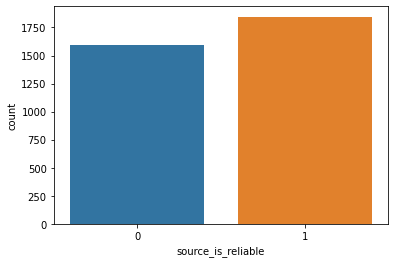

In [300]:
sns.countplot(x='source_is_reliable', data=x_df)

In [301]:
df = x_df

In [32]:
df['fb_popularity'].describe().apply(lambda x: '%.3f' % x)

count      60955.000
mean        1140.041
std        29800.535
min            0.000
25%            0.000
50%            2.000
75%          121.000
max      5197586.000
Name: fb_popularity, dtype: object

In [302]:
def draw_publishing_per_year(df):
    published_in_year = df.published_at.apply(lambda x: x.year)
    with figsize(plt, 20, 5):
        cplt = sns.countplot(published_in_year, color='black')
        cplt.set(xlabel='Rok publikovania', ylabel='Počet článkov')
        return cplt


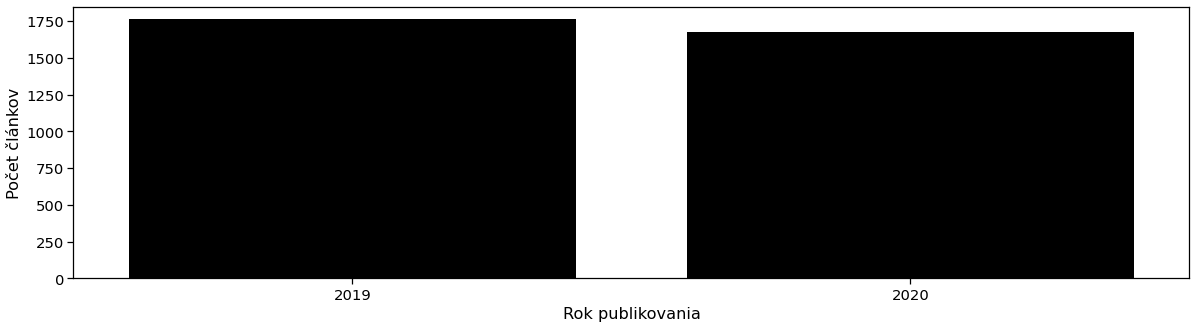

In [303]:
with sns.plotting_context("notebook", font_scale=1.35):
    draw_publishing_per_year(df).get_figure().savefig('export/clanky-per-rok.png')

Cut the articles so we use only those from 2011 - now

In [35]:
df = df[df.published_at > '2011-01-01']

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58179 entries, 0 to 60954
Data columns (total 30 columns):
id                     58179 non-null int64
url                    58179 non-null object
title                  58179 non-null object
perex                  50458 non-null object
body                   58158 non-null object
published_at           58179 non-null datetime64[ns]
extracted_at           58179 non-null datetime64[ns]
source_id              58179 non-null int64
category               49365 non-null object
other_info             58177 non-null object
image_count            58179 non-null int64
video_count            58179 non-null int64
veracity               58179 non-null object
claims_false           58179 non-null int64
claims_mixture         58179 non-null int64
claims_mostly_false    58179 non-null int64
claims_mostly_true     58179 non-null int64
claims_true            58179 non-null int64
claims_unknown         58179 non-null int64
author_name            58179 n

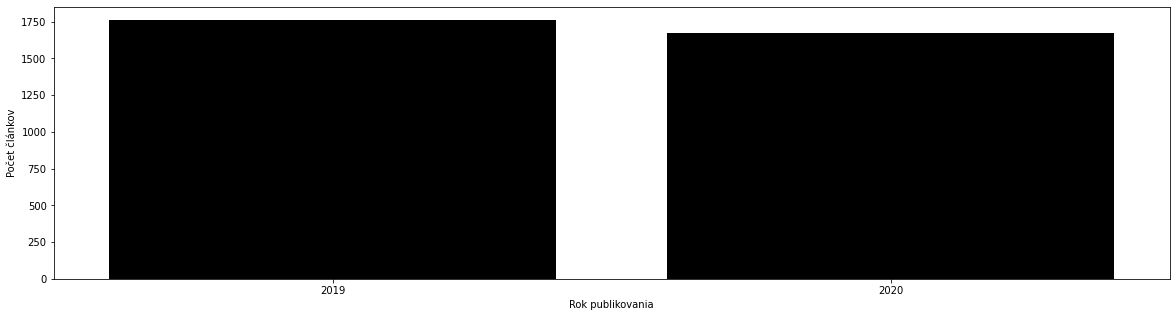

In [304]:
draw_publishing_per_year(df)

In [305]:
df[['source_name', 'source_is_reliable']].groupby('source_name').first()['source_is_reliable'].value_counts()

0    36
1    20
Name: source_is_reliable, dtype: int64

In [320]:
df.source_name.value_counts()

naturalnews.com                  561
medicinenet.com                  395
neurosciencenews.com             231
medicaldaily.com                 228
statnews.com                     166
webmd.com                        145
healthnutnews.com                127
medicalnewstoday.com             124
foxnews.com                      113
healthcentral.com                101
naturalhealth365.com              97
nytimes.com                       84
healthy-holistic-living.com       80
consciouslifenews.com             79
emedicinehealth.com               69
healthimpactnews.com              68
latimes.com                       63
themindunleashed.com              54
vaxopedia.org                     52
collective-evolution.com          51
thenewsdoctors.com                51
organicfacts.net                  47
ageofautism.com                   42
allianceforadvancedhealth.com     42
infowars.com                      41
vaccineimpact.com                 39
hsionline.com                     35
v

In [318]:
df[['source_name', 'source_is_reliable']].values_counts()

AttributeError: 'DataFrame' object has no attribute 'values_counts'

### Save final data

In [321]:
save_df(df, 'final_data.pickle')

In [4]:
import pandas as pd